In [1]:
#@title Import stuff, helper functions...
import datetime
import pandas as pd
import numpy as np
import re as re
import tabulate as tab
import plotnine as p9
import math
import mizani.formatters as mizani
# import warnings

# warnings.filterwarnings('ignore')


from plotnine.themes.themeable import legend_key_width
# in seconds
TIMEOUT = 120
TIMEOUT_VAL = TIMEOUT * 1.1
TIME_MIN = 0.01

# For reading in files
def read_file(filename):
    """Reads a CSV file into Panda's data frame"""
    df_loc = pd.read_csv(
        filename,
        sep=";",
        comment="#",
        na_values=['ERR', 'TO', 'MISSING'],
        # na_values=['TO', 'MISSING'],
        # na_values=['TO'],
        )
    return df_loc

# For reading in files
def read_file_no_nan(filename):
    """Reads a CSV file into Panda's data frame"""
    df_loc = pd.read_csv(
        filename,
        sep=";",
        comment="#",
        # na_values=['ERR', 'TO', 'MISSING'],
        # na_values=['TO', 'MISSING'],
        # na_values=['TO'],
        )
    return df_loc


# For printing scatter plots
def scatter_plot(df, xcol, ycol, domain, xname=None, yname=None, log=False, width=6, height=6, clamp=True, tickCount=5, show_legend=True):
    assert len(domain) == 2

    POINT_SIZE = 1.0
    DASH_PATTERN = (0, (6, 2))

    if xname is None:
        xname = xcol
    if yname is None:
        yname = ycol

    # formatter for axes' labels
    ax_formatter = mizani.custom_format('{:n}')

    if clamp:  # clamp overflowing values if required
        df = df.copy(deep=True)
        df.loc[df[xcol] > domain[1], xcol] = domain[1]
        df.loc[df[ycol] > domain[1], ycol] = domain[1]

    # generate scatter plot
    scatter = p9.ggplot(df)
    scatter += p9.aes(x=xcol, y=ycol, color="benchmark")
    scatter += p9.geom_point(size=POINT_SIZE, na_rm=True, show_legend=show_legend, raster=True)
    scatter += p9.labs(x=xname, y=yname)
    scatter += p9.theme(legend_key_width=2)
    scatter += p9.scale_color_hue(l=0.4, s=0.9, h=0.1)

    # rug plots
    scatter += p9.geom_rug(na_rm=True, sides="tr", alpha=0.05, raster=True)

    if log:  # log scale
        scatter += p9.scale_x_log10(limits=domain, labels=ax_formatter)
        scatter += p9.scale_y_log10(limits=domain, labels=ax_formatter)
    else:
        scatter += p9.scale_x_continuous(limits=domain, labels=ax_formatter)
        scatter += p9.scale_y_continuous(limits=domain, labels=ax_formatter)

    # scatter += p9.theme_xkcd()
    scatter += p9.theme_bw()
    scatter += p9.theme(panel_grid_major=p9.element_line(color='#666666', alpha=0.5))
    scatter += p9.theme(panel_grid_minor=p9.element_blank())
    scatter += p9.theme(figure_size=(width, height))
    scatter += p9.theme(axis_text=p9.element_text(size=24, color="black"))
    scatter += p9.theme(axis_title=p9.element_text(size=24, color="black"))
    scatter += p9.theme(legend_text=p9.element_text(size=12))

    if not show_legend:
        scatter += p9.theme(legend_position='none')

    # generate additional lines
    scatter += p9.geom_abline(intercept=0, slope=1, linetype=DASH_PATTERN)  # diagonal
    scatter += p9.geom_vline(xintercept=domain[1], linetype=DASH_PATTERN)  # vertical rule
    scatter += p9.geom_hline(yintercept=domain[1], linetype=DASH_PATTERN)  # horizontal rule

    res = scatter

    return res


# Print a matrix of plots
def matrix_plot(list_of_plots, cols):
    assert len(list_of_plots) > 0
    assert cols >= 0

    matrix_plot = None
    row = None
    for i in range(0, len(list_of_plots)):
        if i % cols == 0:  # starting a new row
            row = list_of_plots[i]
        else:
            row |= list_of_plots[i]

        if (i + 1) % cols == 0 or i + 1 == len(list_of_plots):  # last chart in a row
            if not matrix_plot:  # first row finished
                matrix_plot = row
            else:
                matrix_plot &= row

    return matrix_plot


# table to LaTeX file
def table_to_file(table, headers, out_file):
    with open(f"plots/{out_file}.tex", mode='w') as fl:
        print(tab.tabulate(table, headers=headers, tablefmt="latex"), file=fl)

# generate evaluation
def gen_evaluation(df, main_tool, all_tools):

    print(f"time:  {datetime.datetime.now()}")
    print(f"# of formulae: {len(df)}")

    summary_times = dict()
    for col in df.columns:
        if re.search('-result$', col):
            summary_times[col] = dict()
            summary_times[col]['timeouts'] = df[col].isna().sum()
            df[col] = df[col].str.strip()
            summary_times[col]['unknowns'] = df[df[col] == "unknown"].shape[0] #[df[col] == "unknown"].shape[0]

    # Remove unknowns
    # df = df.drop(df[df[main_tool + "-result"] == "unknown"].index)
    for tool in all_tools:
      df.loc[df[tool + "-result"] == "unknown", tool + '-runtime'] = np.NaN

    for col in df.columns:
        if re.search('-runtime$', col):
            summary_times[col] = dict()
            summary_times[col]['max'] = df[col].max()
            summary_times[col]['min'] = df[col].min()
            summary_times[col]['mean'] = df[col].mean()
            summary_times[col]['median'] = df[col].median()
            summary_times[col]['std'] = df[col].std()

    df_summary_times = pd.DataFrame(summary_times).transpose()



    tab_interesting = []
    for i in all_tools:
        row = df_summary_times.loc[i + '-runtime']
        unknown_row = dict(df_summary_times.loc[i + '-result'])
        row_dict = dict(row)
        row_dict.update({'name': i})
        tab_interesting.append([row_dict['name'],
                                # row_dict['min'],
                                row_dict['max'],
                                row_dict['mean'],
                                row_dict['median'],
                                row_dict['std'],
                                unknown_row['timeouts'],
                                unknown_row["unknowns"]])

    headers = ["method", "max", "mean", "median", "std. dev", "TO+MO+ERR", "unknowns"]
    print("###################################################################################")
    print("####                                   Table 1                                 ####")
    print("###################################################################################")
    print(tab.tabulate(tab_interesting, headers=headers, tablefmt="github"))
    print("\n\n")

    # sanitizing NAs
    for col in df.columns:
        if re.search('-runtime$', col):
            df[col].fillna(TIMEOUT_VAL, inplace=True)
            df.loc[df[col] < TIME_MIN, col] = TIME_MIN  # to remove 0 (in case of log graph)


    # comparing wins/loses
    compare_methods = []
    for t in all_tools:
      if t == main_tool:
        continue
      compare_methods.append((main_tool + "-runtime", t + "-runtime"))


    # compare_methods = [("noodler-runtime", "z3-runtime"),
    #                    ("noodler-runtime", "cvc4-runtime")
    #                   ]

    tab_wins = []
    for left, right in compare_methods:
        left_over_right = df[df[left] < df[right]]
        right_timeouts = left_over_right[left_over_right[right] == TIMEOUT_VAL]

        right_over_left = df[df[left] > df[right]]
        left_timeouts = right_over_left[right_over_left[left] == TIMEOUT_VAL]

        tab_wins.append([right, len(left_over_right), len(right_timeouts), len(right_over_left), len(left_timeouts)])

    headers_wins = ["method", "wins", "wins-timeouts", "loses", "loses-timeouts"]
    print("######################################################################")
    print("####                             Table 2                          ####")
    print("######################################################################")
    print(tab.tabulate(tab_wins, headers=headers_wins, tablefmt="github"))
    #table_to_file(tab_wins, headers_wins, out_prefix + "_table1right")
    print("\n\n")

    print("##############    other claimed results    ###############")

    ############# the best solution ##########
    # df['other_min-runtime'] = df[
    #     ['cvc4-runtime',]].min(axis=1)


    to_cmp2 = []
    for t in all_tools:
      if t == main_tool:
        continue
      to_cmp2.append({'x': main_tool, 'y': t,
                'xname': NOODLER, 'yname': t,
                'max': TIMEOUT_VAL, 'tickCount': 3})

    # to_cmp2 = [{'x': "noodler", 'y': "cvc4",
    #             'xname': 'Noodler', 'yname': 'CVC4',
    #             'max': TIMEOUT_VAL, 'tickCount': 3},
    #            {'x': "noodler", 'y': "z3",
    #             'xname': 'Noodler', 'yname': 'Z3',
    #             'max': TIMEOUT_VAL, 'tickCount': 3}
    #           ]

    # add fields where not present
    for params in to_cmp2:
        if 'xname' not in params:
            params['xname'] = None
        if 'yname' not in params:
            params['yname'] = None
        if 'max' not in params:
            params['max'] = TIMEOUT_VAL
        if 'tickCount' not in params:
            params['tickCount'] = 5
        if 'filename' not in params:
            params['filename'] = "/home/fig_" + params['x'] + "_vs_" + params['y'] + ".pdf"

    size = 7
    plot_list = [(params['x'],
                  params['y'],
                  params['filename'],
                  scatter_plot(df,
                               xcol=params['x'] + '-runtime',
                               ycol=params['y'] + '-runtime',
                               xname=params['xname'], yname=params['yname'],
                               domain=[TIME_MIN, params['max']],
                               tickCount=params['tickCount'],
                               log=True, width=size+2, height=size)) for params
                 in to_cmp2]

    print("\n\n")
    print("Generating plots...")
    for x, y, filename, plot in plot_list:
        #filename = f"plots/{out_prefix}_{filename}.pdf"
        print(f"plotting x: {x}, y: {y}... saving to {filename}")
        # plot.save(filename, scale_factor=2)
        # plot.save(filename=filename, dpi=1000)
        print(plot)

    # return benchmarks solvable only by 'engine'
    # def only_solves(df, engine):
    #     # select those where engine finishes
    #     res = df[df[engine + '-runtime'] != TIMEOUT_VAL]
    #     for col in res.columns:
    #         if re.search('-runtime$', col) and not re.search(engine, col):
    #             res = res[res[col] == TIMEOUT_VAL]

    #     return res


    # engines = ["z3",
    #            "cvc4",
    #            "noodler"
    #           ]

    # for i in all_tools:
    #     i_only_solves = only_solves(df, i)
    #     print(f"only {i} = " + str(len(i_only_solves)))
    #     if len(i_only_solves) > 0:
    #         print()
    #         print(tab.tabulate(i_only_solves, headers='keys'))
    #         print()

    def none_solves(df):
        # select those where engine finishes
        res = df
        for col in res.columns:
            if re.search('-runtime$', col):
                res = res[res[col] == TIMEOUT_VAL]

        return res

    unsolvable = none_solves(df)
    #print("unsolvable: " + str(len(unsolvable)))
    #print(tab.tabulate(unsolvable, headers='keys'))
    #print("\n\n\n\n\n")

def get_unknowns(df, tool):
  pt = df#[["name", NOODLER+"-result"]]
  pt = pt[(pt[tool+"-result"].str.strip() == 'unknown')]
  return pt
def sanity_check(df, tool, compare_with):
  pt = df#[["name", compare_with+"-result", NOODLER+"-result"]]
  pt = pt[((pt[tool+"-result"].str.strip() == 'sat') & (pt[compare_with+"-result"].str.strip() == 'unsat') | (pt[tool+"-result"].str.strip() == 'unsat') & (pt[compare_with+"-result"].str.strip() == 'sat'))]
  return pt
def check_for_errors(df, tool):
  pt = df#[["name", NOODLER+"-result"]]
  pt = pt[((pt[tool+"-result"].str.strip() != 'sat') & (pt[tool+"-result"].str.strip() != 'unsat') & (pt[tool+"-result"].str.strip() != 'unknown') & (pt[tool+"-result"].str.strip() != 'TO'))]
  return pt
def get_timeouts(df, tool):
  pt = df#[["name", NOODLER+"-result"]]
  pt = pt[(pt[tool+"-result"].str.strip() == 'TO')]
  return pt

In [45]:

# make tables interactive
from itables import init_notebook_mode
import itables.options as opt
init_notebook_mode(all_interactive=True, connected=True)
opt.maxBytes=0

In [2]:
FILES = [
    "sygus_qgen/to120.csv",
    "denghang/to120.csv",
    "automatark/to120.csv",
    "stringfuzz/to120.csv",

    "norn/to120.csv",
    "slog/to120.csv",
    "slent/to120.csv",
    #"transducer_plus/to120.csv",
    "kaluza/to120.csv",
    "webapp/to120.csv",
    "kepler/to120.csv",
    "woorpje/to120.csv",

    "leetcode/to120.csv",
    "str_small_rw/to120.csv",
    #"full_str_int/to120.csv",
    "pyex/to120.csv",
    ]

NOODLER = "z3-noodler-feada45-a57f582"

TOOLS = [
    NOODLER,

    ### OTHER TOOLS ###

    # NOT run with 8GB limit (and some of them are not complete + at some point pycobench got broken and set 60s TO always)
    # "cvc5-1.0.5",
    # "z3-4.12.1",
    # "z3-4.12.2-nomem",
    # "z3-trau",
    # "z3strRE-nomem",
    # "z3str4-nomem",
    # "ostrich-1.2", # run with ol
    # "ostrich-1.3",

    # run with 8GB limit (they should be also complete, and pycobench works probably correctly)
    "cvc5-1.0.8",
    "z3-4.12.2",
    #"z3str4",
    #"ostrich-70d01e2d2", # 1.3 with some extra commits that seems to fix some bugs + run with '-portfolio=strings'
    "ostrich-70d01e2d2-parikh", # same as previous but also run with +parikh (not run on pyex)
    #"z3strRE",
    #"z3-trau-1.1",

    ### PREVIOUS NOODLER VERSIONS ###

    # noodler from the paper
    # "z3-noodler-9f5e602",
    # "z3-noodler-9f5e602-underapprox", # for kaluza

    # # noodler that was run on everything except pyex (but there was some problem with stringfuzz and leetcode)
    # "z3-noodler-6e14cda",
    # # noodler that was run on everything except pyex (with infinite loop thingy)
    # "z3-noodler-59658f7",
    # # noodler that was run on everything except pyex (without infinite loop thingy)
    # "z3-noodler-e8a4269",

    # noodler that was run on everything (with wrong results on pyex)
    # "z3-noodler-daa40de",
    # noodler that was run on everything (with wrong results on pyex)
    # "z3-noodler-5f32279",

    # noodler after merging PR64: Regex construction optimization (right before refactoring, with bug in mata for removing unused states - 3 norn and 190 pyex bad)
    #"z3-noodler-49295a5-8781b7d",

    # noodler after refactoring that was run on everything (with bug in mata for removing unused states - 3 wrong results on norn)
    # "z3-noodler-d1676a5-8781b7d",
    # "z3-noodler-d1676a5-8781b7d-underapprox",
    # "z3-noodler-d1676a5-8781b7d-nielsen",

    # noodler after refactoring, with fixed bug in mata
    # "z3-noodler-loop-13af422-5fa5ea0",
    # "z3-noodler-13af422-5fa5ea0",

    # just before merging branch opt-pred-inst
    # "z3-noodler-d83b1b9-2f0ef53",

    # just before merging loop-protection-fix
    # "z3-noodler-loop-1a1ac35-2f0ef53",
    # "z3-noodler-loop-mem", # 1a1ac35-2f0ef53 but with 8GB memory limit

    ### Everything after this has loop protection by default + is run with 8GB memory limit

    # just before merging regex-info
    # "z3-noodler-381ffd1-2f0ef53",

    # from dec-proc-default, both run only with either nielsen or underapproximation allowed
    # "z3-noodler-nielsen-0746e08-8ba88ce",
    # "z3-noodler-underapprox-ab28d76-2f0ef53",

    # str_int where dec-proc-default was not yet in
    # "z3-noodler-63aa361-8ba88ce",

    ### Everything after this has also nielsen and underapproximation on by default
    
    # devel after merging nielsen_first
    # "z3-noodler-a0e3745-8ba88ce",

    # just before merging new_mata
    # "z3-noodler-0ae38ae-40ca1cd",

    # after updating to z3 v4.12.2
    # "z3-noodler-1ba1904-40ca1cd"

    # noodler stays the same, but we update mata
    # "z3-noodler-f211b89-7831cdc",
    #"z3-noodler-f211b89-bb85433",
    "z3-noodler-1482571-a57f582"
    ]

dfs = dict()
dfs_no_nan = dict()
for file in FILES:
  df = read_file(file)
  df["benchmark"] = file
  dfs[file] = df
  df = read_file_no_nan(file)
  df["benchmark"] = file
  dfs_no_nan[file] = df
# df_all is used for generating results, we select only columns with used tools
df_all = pd.concat(dfs)[["name"] + [f(tool) for tool in TOOLS for f in (lambda x: x+"-result", lambda x: x+"-runtime")] + ["benchmark"]]
# df_all_no_nan is used for checking if noodler gives correct results, we select only columns with used tools + only result columns are needed
df_all_no_nan = pd.concat(dfs_no_nan)[["name"] + [tool+"-result" for tool in TOOLS]]
# df_all_no_nan = df_all_no_nan[df_all_no_nan["z3-noodler-f211b89-bb85433-result"] != " unknown"]

/var/folders/k8/vb71jppj43x35pc3qvksjy4w0000gn/T/ipykernel_1240/4281331535.py:37: DtypeWarning: Columns (35,43,47,57,59,61,63,65) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/k8/vb71jppj43x35pc3qvksjy4w0000gn/T/ipykernel_1240/4281331535.py:37: DtypeWarning: Columns (1,3,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,99,101,103,105,107,109,111,113,115,117,119,121,123,125,127,129,131,133,135,137,139,141,143) have mixed types. Specify dtype option on import or set low_memory=False.


Sanity check

In [3]:
# get all formulae where noodler gives different result than sat/unsat/unknown/TO
res = check_for_errors(df_all_no_nan, NOODLER)

# filter memouts (just kinda heuristics, we assume all ERR for last run (assumed to be last in TOOLS) were memout, so we assume they are still memouts)
# res[(res[TOOLS[-1] + "-result"] != "ERR")]

# show those where we do not give "ERR" (i.e. some bullshit)
# res[(res[NOODLER + '-result'] != "ERR")]

# show everything
res

name  \
kaluza/to120.csv 7324   ../formulae/QF_SLIA/20180523-Reynolds/kaluza/u...   
webapp/to120.csv 244    ../formulae/QF_SLIA/20230403-webapp/lan-rep/la...   
                 272    ../formulae/QF_SLIA/20230403-webapp/lan-rep/la...   
                 301    ../formulae/QF_SLIA/20230403-webapp/lan-rep/la...   
                 307    ../formulae/QF_SLIA/20230403-webapp/lan-rep/la...   
...                                                                   ...   
pyex/to120.csv   22499  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   
                 22509  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   
                 22631  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   
                 23303  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   
                 23671  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   

                       z3-noodler-feada45-a57f582-result cvc5-1.0.8-result  \
kaluza/to120.csv 7324                                ERR               sat   
webapp/to120.csv 244                                 ERR               sat   
                 272                                 ERR               sat   
                 301                                 ERR                TO   
                 307                                 ERR               sat   
...                                                  ...               ...   
pyex/to120.csv   22499                               ERR               sat   
                 22509                               ERR               sat   
                 22631                               ERR               sat   
                 23303                               ERR               sat   
                 23671                               ERR               sat   

                       z3-4.12.2-result ostrich-70d01e2d2-parikh-result  \
kaluza/to120.csv 7324                TO                             ERR   
webapp/to120.csv 244            unknown                             ERR   
                 272            unknown                              TO   
                 301            unknown                             ERR   
                 307            unknown                              TO   
...                                 ...                             ...   
pyex/to120.csv   22499              sat                             NaN   
                 22509              sat                             NaN   
                 22631              sat                             NaN   
                 23303              sat                             NaN   
                 23671              sat                             NaN   

                       z3-noodler-1482571-a57f582-result  
kaluza/to120.csv 7324                                ERR  
webapp/to120.csv 244                             unknown  
                 272                             unknown  
                 301                             unknown  
                 307                             unknown  
...                                                  ...  
pyex/to120.csv   22499                                TO  
                 22509                               ERR  
                 22631                               ERR  
                 23303                               ERR  
                 23671                               ERR  

[1239 rows x 6 columns]

In [4]:
# check if noodler does not return different result than other solvers (i.e. wrong sat/unsat)
all_bad = [sanity_check(df_all_no_nan, NOODLER, tool) for tool in TOOLS if tool != NOODLER]
# merged = all_bad[0]
# for bad in all_bad[1:]:
#   merged = pd.merge(merged, bad, on='name', how='outer')
# merged
pd.concat(all_bad).drop_duplicates()

name  \
str_small_rw/to120.csv 1610  ../formulae/QF_SLIA/20190311-str-small-rw-Noet...   
                       1841  ../formulae/QF_SLIA/20190311-str-small-rw-Noet...   
                       1485  ../formulae/QF_SLIA/20190311-str-small-rw-Noet...   
                       1801  ../formulae/QF_SLIA/20190311-str-small-rw-Noet...   

                            z3-noodler-feada45-a57f582-result  \
str_small_rw/to120.csv 1610                             unsat   
                       1841                             unsat   
                       1485                             unsat   
                       1801                             unsat   

                            cvc5-1.0.8-result z3-4.12.2-result  \
str_small_rw/to120.csv 1610               sat               TO   
                       1841               sat               TO   
                       1485             unsat            unsat   
                       1801             unsat            unsat   

                            ostrich-70d01e2d2-parikh-result  \
str_small_rw/to120.csv 1610                           unsat   
                       1841                           unsat   
                       1485                             sat   
                       1801                             sat   

                            z3-noodler-1482571-a57f582-result  
str_small_rw/to120.csv 1610                             unsat  
                       1841                             unsat  
                       1485                             unsat  
                       1801                             unsat

In [5]:
get_timeouts(df_all_no_nan, NOODLER)
# pt = df_all_no_nan
# pt = pt[((pt[NOODLER+"-result"].str.strip() == 'TO') & (pt[TOOLS[-1] + "-result"].str.strip() != 'TO'))]
# print(pt.to_csv())
# pt

name  \
automatark/to120.csv 3268   ../formulae/QF_S/20230329-automatark-lu/instan...   
                     6469   ../formulae/QF_S/20230329-automatark-lu/instan...   
                     6575   ../formulae/QF_S/20230329-automatark-lu/instan...   
                     6603   ../formulae/QF_S/20230329-automatark-lu/instan...   
                     6634   ../formulae/QF_S/20230329-automatark-lu/instan...   
...                                                                       ...   
pyex/to120.csv       23791  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   
                     23796  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   
                     23805  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   
                     23827  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   
                     23830  ../formulae/QF_SLIA/20180523-Reynolds/pyex/pet...   

                           z3-noodler-feada45-a57f582-result  \
automatark/to120.csv 3268                                 TO   
                     6469                                 TO   
                     6575                                 TO   
                     6603                                 TO   
                     6634                                 TO   
...                                                      ...   
pyex/to120.csv       23791                                TO   
                     23796                                TO   
                     23805                                TO   
                     23827                                TO   
                     23830                                TO   

                           cvc5-1.0.8-result z3-4.12.2-result  \
automatark/to120.csv 3268                sat              sat   
                     6469                sat              sat   
                     6575                sat              sat   
                     6603                sat              sat   
                     6634              unsat            unsat   
...                                      ...              ...   
pyex/to120.csv       23791               sat              sat   
                     23796             unsat               TO   
                     23805               sat              sat   
                     23827               sat              sat   
                     23830               sat              sat   

                           ostrich-70d01e2d2-parikh-result  \
automatark/to120.csv 3268                               TO   
                     6469                              ERR   
                     6575                              ERR   
                     6603                              ERR   
                     6634                            unsat   
...                                                    ...   
pyex/to120.csv       23791                             NaN   
                     23796                             NaN   
                     23805                             NaN   
                     23827                             NaN   
                     23830                             NaN   

                           z3-noodler-1482571-a57f582-result  
automatark/to120.csv 3268                                 TO  
                     6469                                 TO  
                     6575                                 TO  
                     6603                                 TO  
                     6634                                 TO  
...                                                      ...  
pyex/to120.csv       23791                                TO  
                     23796                                TO  
                     23805                                TO  
                     23827                                TO  
                     23830                                TO  

[959 rows x 6 columns]

In [6]:
get_unknowns(df_all_no_nan, NOODLER)
# pt = df_all_no_nan
# pt[((pt[NOODLER+"-result"].str.strip() == 'unsat') & (pt[TOOLS[-1] + "-result"].str.strip() == 'unknown'))]

name  \
stringfuzz/to120.csv   12    ../formulae/QF_SLIA/20230327-stringfuzz-lu/tra...   
                       13    ../formulae/QF_SLIA/20230327-stringfuzz-lu/tra...   
                       15    ../formulae/QF_SLIA/20230327-stringfuzz-lu/tra...   
                       16    ../formulae/QF_SLIA/20230327-stringfuzz-lu/tra...   
                       25    ../formulae/QF_SLIA/20230327-stringfuzz-lu/tra...   
...                                                                        ...   
str_small_rw/to120.csv 1794  ../formulae/QF_SLIA/20190311-str-small-rw-Noet...   
                       1815  ../formulae/QF_SLIA/20190311-str-small-rw-Noet...   
                       1817  ../formulae/QF_SLIA/20190311-str-small-rw-Noet...   
                       1827  ../formulae/QF_SLIA/20190311-str-small-rw-Noet...   
                       1846  ../formulae/QF_SLIA/20190311-str-small-rw-Noet...   

                            z3-noodler-feada45-a57f582-result  \
stringfuzz/to120.csv   12                             unknown   
                       13                             unknown   
                       15                             unknown   
                       16                             unknown   
                       25                             unknown   
...                                                       ...   
str_small_rw/to120.csv 1794                           unknown   
                       1815                           unknown   
                       1817                           unknown   
                       1827                           unknown   
                       1846                           unknown   

                            cvc5-1.0.8-result z3-4.12.2-result  \
stringfuzz/to120.csv   12               unsat            unsat   
                       13                 sat              sat   
                       15               unsat            unsat   
                       16               unsat            unsat   
                       25                 sat              sat   
...                                       ...              ...   
str_small_rw/to120.csv 1794             unsat            unsat   
                       1815             unsat            unsat   
                       1817             unsat            unsat   
                       1827             unsat               TO   
                       1846             unsat            unsat   

                            ostrich-70d01e2d2-parikh-result  \
stringfuzz/to120.csv   12                             unsat   
                       13                                TO   
                       15                             unsat   
                       16                             unsat   
                       25                               sat   
...                                                     ...   
str_small_rw/to120.csv 1794                              TO   
                       1815                              TO   
                       1817                              TO   
                       1827                              TO   
                       1846                              TO   

                            z3-noodler-1482571-a57f582-result  
stringfuzz/to120.csv   12                             unknown  
                       13                             unknown  
                       15                             unknown  
                       16                             unknown  
                       25                             unknown  
...                                                       ...  
str_small_rw/to120.csv 1794                           unknown  
                       1815                           unknown  
                       1817                           unknown  
                       1827                           unknown  
                       1846                           

time:  2024-01-03 12:39:17.061414
# of formulae: 82972
###################################################################################
####                                   Table 1                                 ####
###################################################################################
| method                     |    max |     mean |   median |   std. dev |   TO+MO+ERR |   unknowns |
|----------------------------|--------|----------|----------|------------|-------------|------------|
| z3-noodler-feada45-a57f582 | 116.1  | 0.494545 |     0.02 |    3.67665 |        2198 |       2011 |
| cvc5-1.0.8                 | 119.36 | 0.515113 |     0.02 |    5.2351  |        1723 |          2 |
| z3-4.12.2                  | 119.29 | 1.49018  |     0.04 |    8.17615 |        2623 |        123 |
| ostrich-70d01e2d2-parikh   | 577.7  | 5.35069  |     2.47 |   11.7293  |       25162 |          0 |
| z3-noodler-1482571-a57f582 | 115.42 | 0.463528 |     0.02 |    3.42857 |       

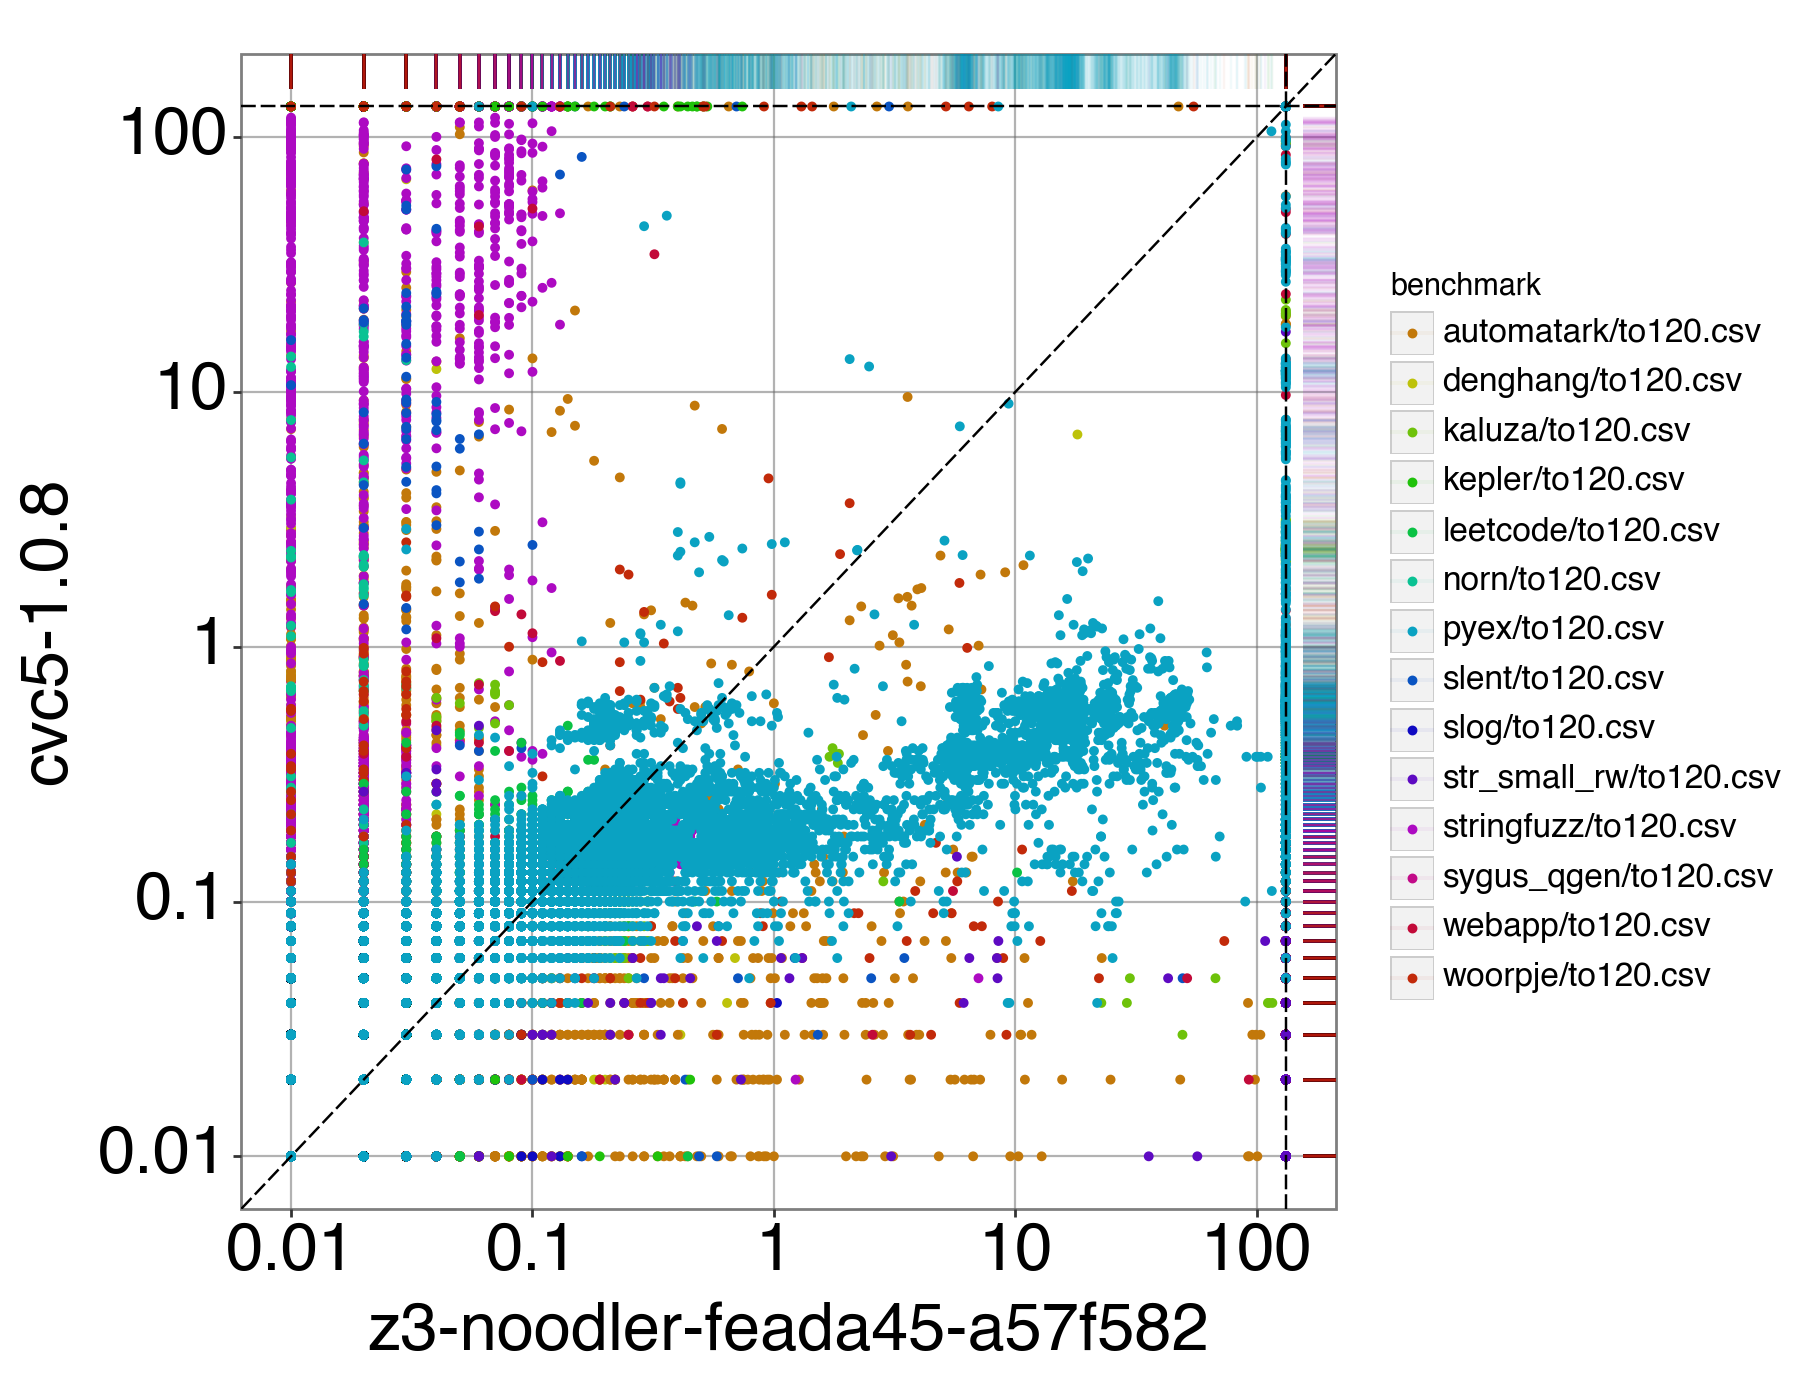


plotting x: z3-noodler-feada45-a57f582, y: z3-4.12.2... saving to /home/fig_z3-noodler-feada45-a57f582_vs_z3-4.12.2.pdf


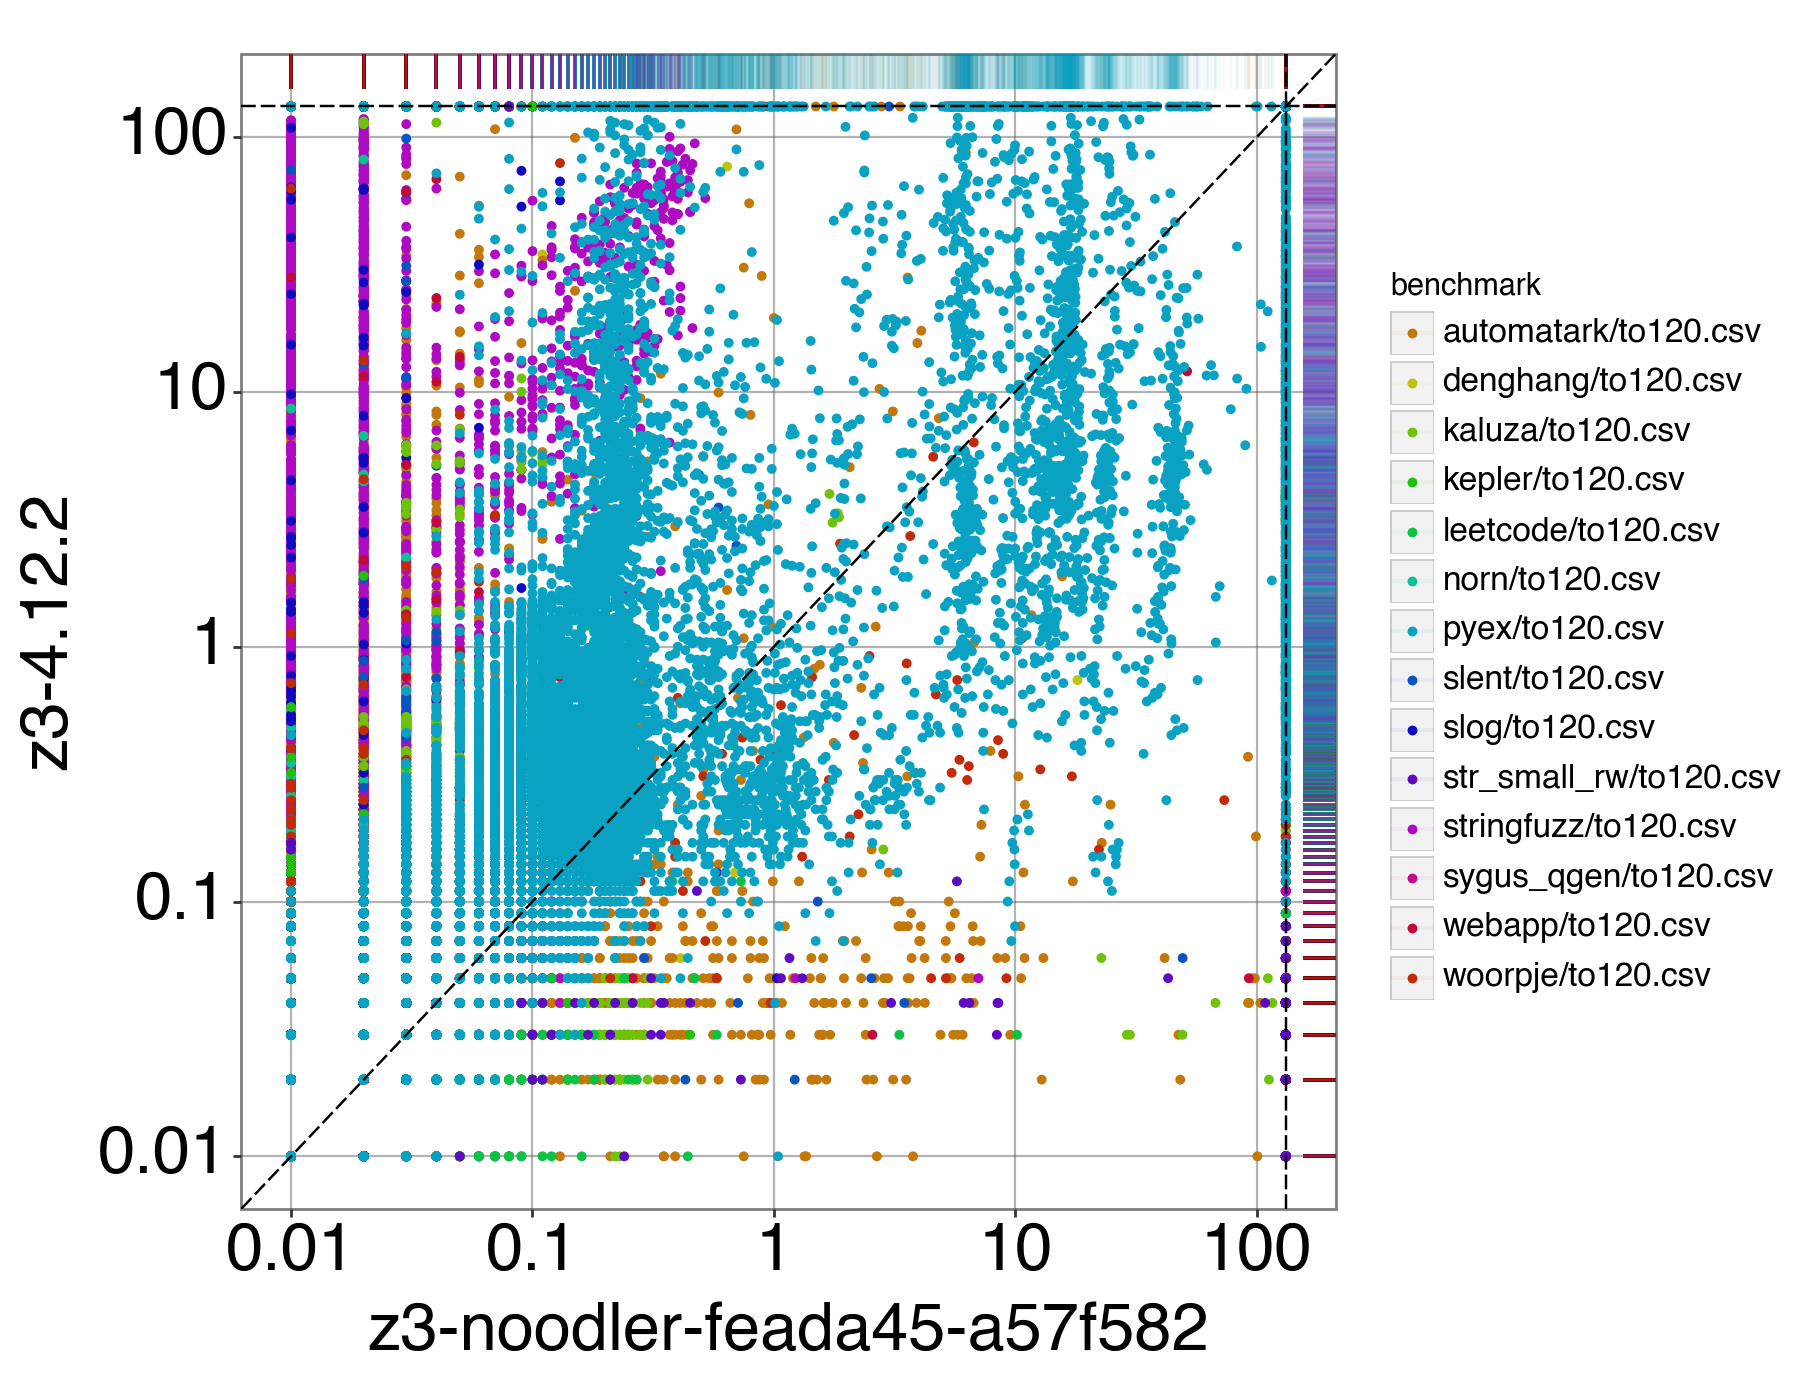


plotting x: z3-noodler-feada45-a57f582, y: ostrich-70d01e2d2-parikh... saving to /home/fig_z3-noodler-feada45-a57f582_vs_ostrich-70d01e2d2-parikh.pdf


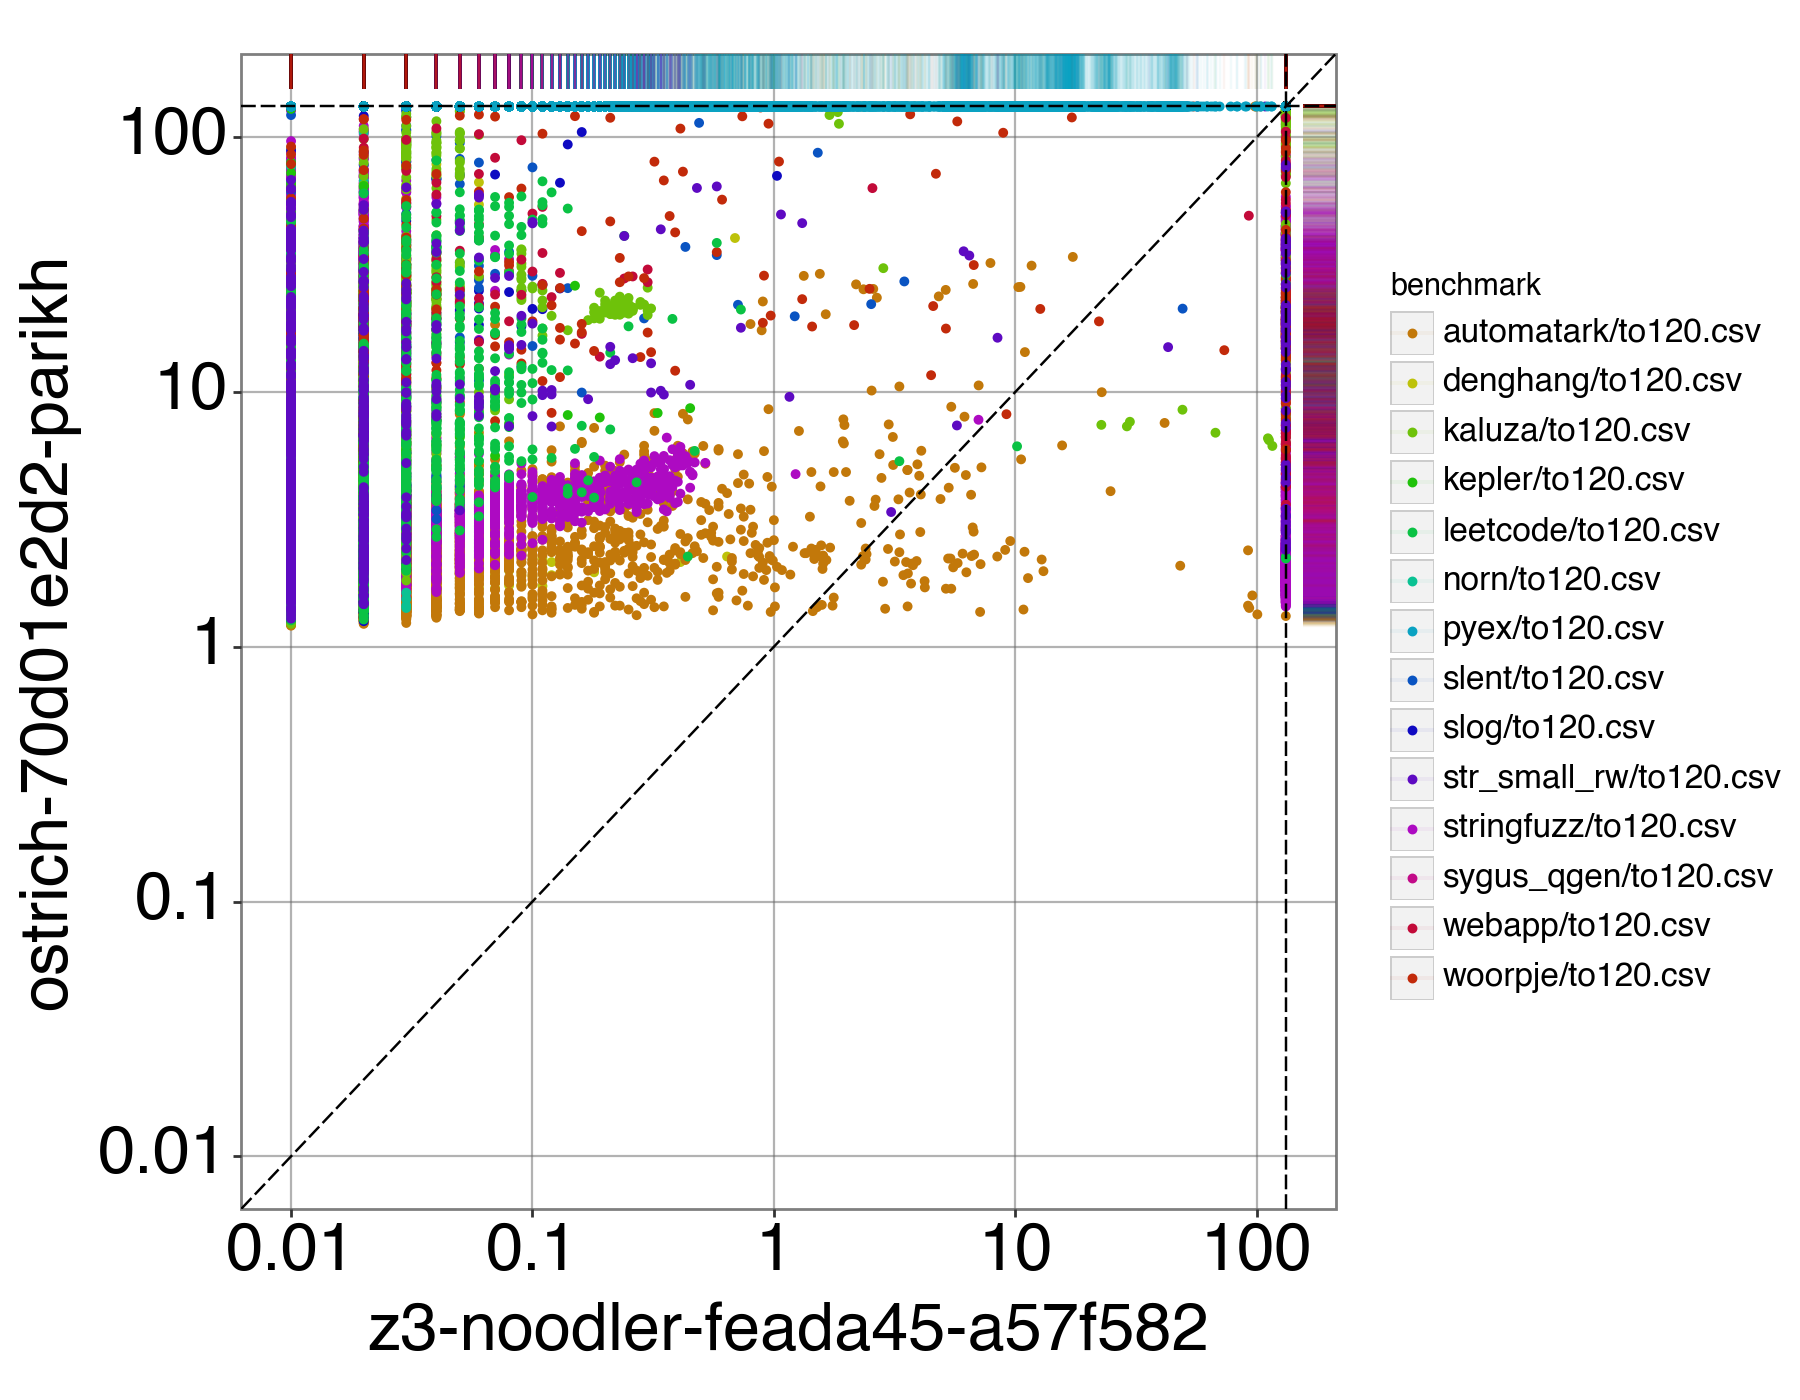


plotting x: z3-noodler-feada45-a57f582, y: z3-noodler-1482571-a57f582... saving to /home/fig_z3-noodler-feada45-a57f582_vs_z3-noodler-1482571-a57f582.pdf


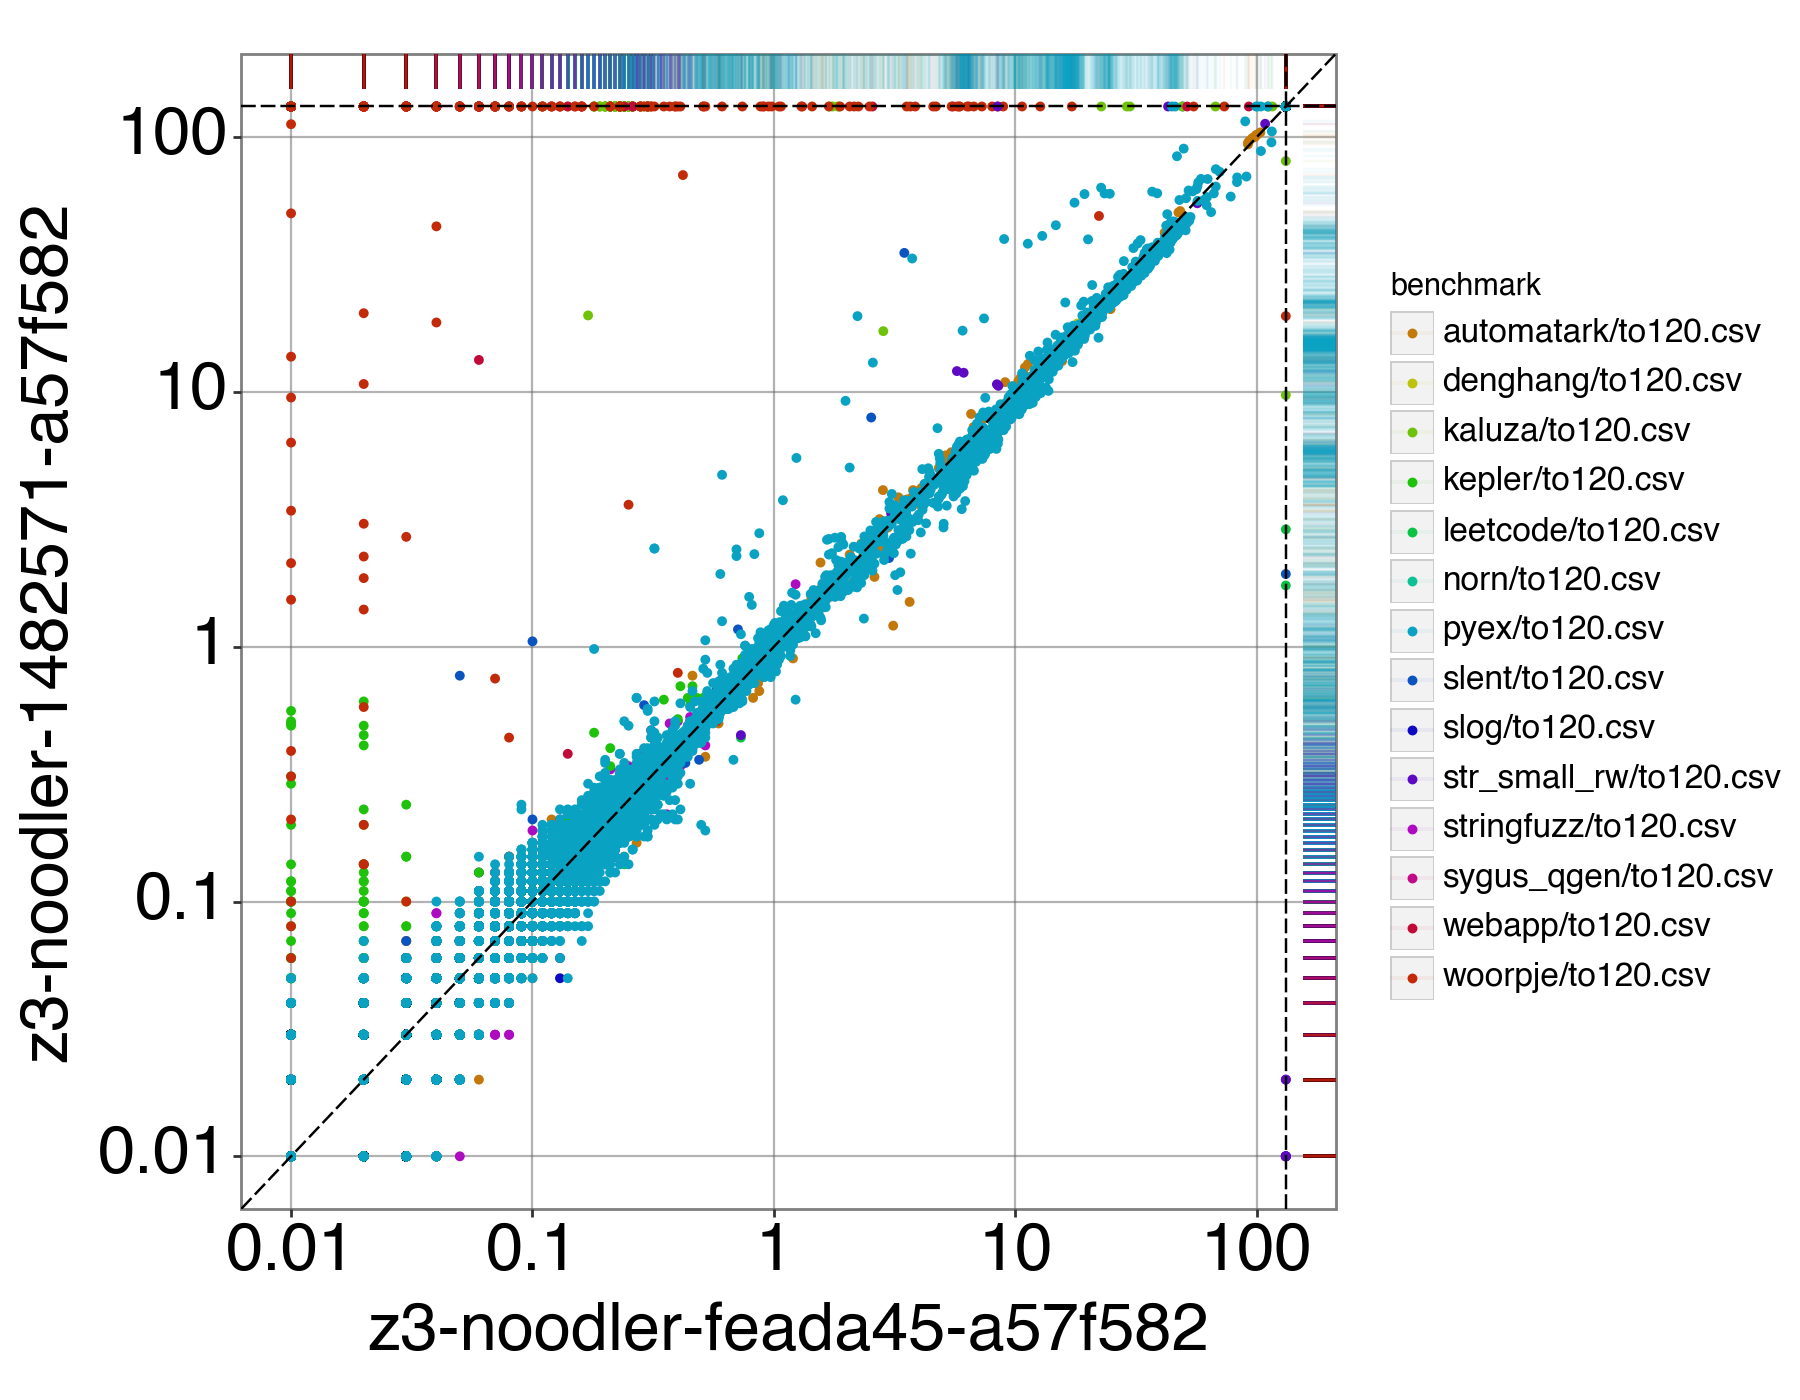

In [7]:
gen_evaluation(df_all, NOODLER, TOOLS)

In [ ]:
header = ["tool", "✅", "❌", "avg", "med", "time", "sat", "unsat", "unknown", "TO", "MO+ERR", "other"]
for bench in FILES:
    df = read_file_no_nan(bench)
    df = df[df["z3-noodler-f211b89-bb85433-result"] != " unknown"]
    print(f"Benchmark {bench}")
    print(f"# of formulae: {len(df)}")
    print("--------------------------------------------------")
    table = [header]
    for tool in TOOLS:
        if tool == "z3-trau-1.1" and bench.startswith("transducer_plus"): # trau gives only errors, so "z3-trau-1.1" does not exist in df
            table.append([tool, 0, len(df), "-", "-", 0,0,0,0,len(df),0])
            continue
        sat = len(df[df[tool + "-result"] == " sat"])
        unsat = len(df[df[tool + "-result"] == " unsat"])
        solved = df[(df[tool + "-result"] == " sat") | (df[tool + '-result'] == " unsat")][f"{tool}-runtime"].astype(float)
        avg_solved = solved.mean()
        median_solved = solved.median()
        total_solved = solved.sum()
        unknown = len(df[df[tool + "-result"] == " unknown"])
        to = len(df[df[tool + "-result"] == "TO"])
        err = len(df[df[tool + "-result"] == "ERR"])
        other = len(df[(df[tool + "-result"] != "ERR") & (df[tool + "-result"] != "TO") & (df[tool + "-result"] != " unknown") & (df[tool + "-result"] != " unsat") & (df[tool + "-result"] != " sat")])
        table.append([tool, sat+unsat, unknown+to+err+other, avg_solved, median_solved, total_solved, sat, unsat, unknown, to, err, other])
    print(tab.tabulate(table, headers='firstrow', floatfmt=".2f"))
    print("--------------------------------------------------")
    print()

In [ ]:
NOODLER_FOR_BENCHMARK = "z3-noodler-f211b89-bb85433"
CVC5 = "cvc5-1.0.8"
Z3 = "z3-4.12.2"
Z3STR4 = "z3str4"
OSTRICH = "ostrich-70d01e2d2"
Z3STR3RE = "z3strRE"
Z3TRAU = "z3-trau-1.1"
OLD_NOODLER = "z3-noodler-9f5e602-199b36d"
tools_for_comparison = [
    NOODLER_FOR_BENCHMARK,
    CVC5,
    Z3,
    Z3STR4,
    OSTRICH,
    Z3STR3RE,
    # Z3TRAU,
    OLD_NOODLER,
]

#
tool_latex_mapping = {
    NOODLER_FOR_BENCHMARK : "\\ziiinoodler",
    CVC5 : "\\cvcv",
    Z3 : "\\ziii",
    Z3STR4 : "\\ziiistriv",
    OSTRICH : "\\ostrich",
    Z3STR3RE : "\\ziiistriiire",
    Z3TRAU : "\\ziiitrau",
    OLD_NOODLER : "\\ziiinoodleroopsla",
}
tool_names_mapping = {
    NOODLER_FOR_BENCHMARK : "Z3-Noodler",
    CVC5 : "cvc5",
    Z3 : "Z3",
    Z3STR4 : "Z3stsr4",
    OSTRICH : "OSTRICH",
    Z3STR3RE : "Z3str3RE",
    Z3TRAU : "Z3-Trau",
    OLD_NOODLER : "Z3-Noodler*",
}
tool_file_names_mapping = {
    NOODLER_FOR_BENCHMARK : "noodler",
    CVC5 : "cvc5",
    Z3 : "z3",
    Z3STR4 : "z3str4",
    OSTRICH : "ostrich",
    Z3STR3RE : "z3str3re",
    Z3TRAU : "z3trau",
    OLD_NOODLER : "old_noodler",
}
bench_mapping = {
    "automatark" : "\\automatark",
    "denghang" : "\\denghang",
    "stringfuzz" : "\\stringfuzz",
    "sygus_qgen" : "\sygusqgen",
    "kaluza" : "\\kaluza",
    "kepler" : "\\keplerbench",
    "norn" : "\\nornbench",
    "slent" : "\\slent",
    "slog" : "\\slog",
    "webapp" : "\\webapp",
    "woorpje" : "\\woorpje",
    "full_str_int" : "\\fullstrint",
    "leetcode" : "\\leetcode",
    "str_small_rw" : "\\strsmall",
    "pyex" : "\\pyex",
    "transducer_plus" : "\\transducerplus",
}
bench_div = {
    "Regex" : ["automatark", "denghang", "stringfuzz", "sygus_qgen"],
    "Equations" : ["kaluza", "kepler", "norn", "slent", "slog", "webapp", "woorpje"],
    "Predicates" : ["full_str_int", "leetcode", "str_small_rw"],# "pyex", "transducer_plus"],
    # "" : ["pyex"]
}
bench_div_mapping = {
    "Regex" : "\\regexbench",
    "Equations" : "\\eqbench",
    "Predicates" : "\\predbench",
    "" : "",
}

In [ ]:

# bench_div = { n : [n] for n in ["automatark", "denghang", "stringfuzz", "sygus_qgen", "kaluza", "kepler", "norn", "slent", "slog", "webapp", "woorpje", "full_str_int", "leetcode", "str_small_rw", "pyex"] }
table = dict()
dfs_here = []
for benchset, benchmarks in bench_div.items():
    dfs = []
    for bench in benchmarks:
        df = read_file_no_nan(bench + "/to120.csv")
        if bench in ["stringfuzz", "webapp", "full_str_int", "str_small_rw"]:
            df = df[df[f"{NOODLER_FOR_BENCHMARK}-result"] != " unknown"]
        dfs.append(df)
    df = pd.concat(dfs)
    df = df[["name"] + [f"{tool}-result" for tool in tools_for_comparison] + [f"{tool}-runtime" for tool in tools_for_comparison]]
    total = len(df)

    # we can help ostrich by substracting some value pretending it is the time for java to start
    # ostrich_solved = df[(df["{OSTRICH}-result"] == " sat")|(df["{OSTRICH}-result"] == " unsat")]
    # df.loc[(df["{OSTRICH}-result"] == " sat")|(df["{OSTRICH}-result"] == " unsat"), "{OSTRICH}-runtime"] = (ostrich_solved['{OSTRICH}-runtime'].astype(float)- 1.3).astype(str)

    total_time_for_tools = 0

    for tool in tools_for_comparison:
        df.loc[(df[f"{tool}-result"] != " sat")&(df[f"{tool}-result"] != " unsat")&(df[f"{tool}-result"] != " unknown"), f"{tool}-runtime"] = 120
        df[f"{tool}-runtime"] = df[f"{tool}-runtime"].astype(float)

        solved = df[(df[tool + "-result"] == " sat") | (df[tool + '-result'] == " unsat")]
        unknown_sum = len(df[df[tool + "-result"] == " unknown"])
        solved_num = len(solved)
        solved_runtime = solved[f"{tool}-runtime"].astype(float)
        # solved_runtime = df[f"{tool}-runtime"].astype(float)
        solved_avg = solved_runtime.mean()
        solved_median = solved_runtime.median()
        solved_total = solved_runtime.sum()
        total_time_for_tools += solved_total
        solved_std_deviation = solved_runtime.std()
        table.setdefault(tool_latex_mapping[tool], []).extend(
            [
                # total - solved_num,
                solved_total,
                # solved_avg,
                # solved_median,
                # solved_std_deviation,
            ])
    
    # table.setdefault("sum", []).extend([(total_time_for_tools/60)/60])


    # virtual best
    def add_vbs_from_tools(tools_list, name_for_vbs, latex_name_for_vbs):
        df[name_for_vbs] = df[[f"{tool}-runtime" for tool in tools_list]].min(axis=1)
        solved_vbs = df[df[name_for_vbs] != 120][name_for_vbs]
        table.setdefault(latex_name_for_vbs, []).extend(
            [
                # total - len(solved_vbs),
                solved_vbs.sum(),
                # solved_vbs.mean(),
                # solved_vbs.median(),
                # solved_vbs.std(),
            ])
    tools_without_old_noodler = [tool for tool in tools_for_comparison if tool != OLD_NOODLER]
    # add_vbs_from_tools(tools_without_old_noodler, "vbs", "\\vbs")
    # for tool in tools_without_old_noodler:
    #     add_vbs_from_tools([tool1 for tool1 in tools_without_old_noodler if tool1 != tool], f"vbs-{tool}", f"\\vbs - {tool_latex_mapping[tool]}")
    # add_vbs_from_tools([CVC5, Z3, NOODLER_FOR_BENCHMARK], "cvc5-z3-noodler", f"{tool_latex_mapping[CVC5]} + {tool_latex_mapping[Z3]} + {tool_latex_mapping[NOODLER_FOR_BENCHMARK]}")
    add_vbs_from_tools([CVC5, Z3], "cvc5-z3", f"{tool_latex_mapping[CVC5]} + {tool_latex_mapping[Z3]}")

    df["benchmark"] = benchset
    dfs_here.append(df)
dfff = pd.concat(dfs_here)

header = pd.MultiIndex.from_product(
    [
        # ['Reg','Eq','Pred','Pyex'],
        list(bench_div.keys()),
        # ['Unsolved','Total time','Avg','Med','Std']
        ['Total time']
    ], names=['',''])
# table_df = pd.DataFrame.from_dict(table, 'index', columns=header)
# table_df = table_df.style.format(precision=2)#, decimal=',', thousands='.')
# print(table_df.to_latex())
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print(pd.DataFrame.from_dict(table, 'index', columns=header).to_string())

# for tool in tools_for_comparison:
#     if tool != NOODLER_FOR_BENCHMARK:
#         scat = scatter_plot(dfff, xcol=f'{NOODLER_FOR_BENCHMARK}-runtime', ycol= f'{tool}-runtime',
#                             xname=tool_names_mapping[NOODLER_FOR_BENCHMARK],        yname=tool_names_mapping[tool],
#                             domain=[TIME_MIN, 120], tickCount=3, log=True, width=6, height=6, show_legend=False)
#         print(scat)
#         scat.save(filename=f"{tool_file_names_mapping[NOODLER_FOR_BENCHMARK]}_vs_{tool_file_names_mapping[tool]}_pyex.pdf", dpi=500, verbose = False)

# scat_vbs = scatter_plot(dfff, xcol=f'{NOODLER_FOR_BENCHMARK}-runtime', ycol= f'vbs-{NOODLER_FOR_BENCHMARK}',
#                     xname=tool_names_mapping[NOODLER_FOR_BENCHMARK],        yname="Virtual Best Solver",
#                     domain=[TIME_MIN, 120], tickCount=3, log=True, width=6, height=6, show_legend=False)
# print(scat_vbs)
# scat_vbs.save(filename=f"{tool_file_names_mapping[NOODLER_FOR_BENCHMARK]}_vs_vbs.pdf", dpi=500, verbose = False)

scat_vbs = scatter_plot(dfff, xcol=f'{NOODLER_FOR_BENCHMARK}-runtime', ycol= f'cvc5-z3',
                    xname="Noodler",        yname="cvc5 + Z3",
                    domain=[TIME_MIN, 120], tickCount=3, log=True, width=6, height=6, show_legend=False)
print(scat_vbs)
scat_vbs.save(filename=f"{tool_file_names_mapping[NOODLER_FOR_BENCHMARK]}_vs_{tool_file_names_mapping[CVC5]}_and_{tool_file_names_mapping[Z3]}.pdf", dpi=500, verbose = False)

In [ ]:
print(R"""\newcolumntype{g}{>{\columncolor{gray!30}}r}
\newcolumntype{f}{>{\columncolor{gray!30}}l}
\newcolumntype{h}{>{\columncolor{gray!30}}c}""")

# for printing best
print(R"\newcommand{\ping}[0]{\bf}")

# for printing those that have wrong results
print(R"""\newcommand{\wrongres}[2]{${}^*${#1}}
% if you want wrong results to be shown in parentheses, uncomment this
% \newcommand{\wrongres}[2]{${}^*${#1}({#2})}""")

tabular_begin = R"\begin{tabular}{l"
col_type = "g"
for benches in bench_div.values():
    tabular_begin += (len(benches)+1)*col_type
    if col_type == "g":
        col_type = "r"
    else:
        col_type = "g"
print(tabular_begin + R"""}
\toprule""")

header_line1 = ""
header_line2 = ""
usedbenchmarks = 2
cmidrules = ""
col_type = "h"
for bench_cat, bench_set in bench_div.items():
    num_of_bench = len(bench_set) + 1
    header_line1 += f" & \\multicolumn{{{num_of_bench}}}{{{col_type}}}{{{bench_div_mapping[bench_cat]}}}"
    cmidrules += f"\\cmidrule(lr){{{usedbenchmarks}-{usedbenchmarks+num_of_bench-1}}}"
    usedbenchmarks += num_of_bench
    header_line2 += " & " + " & ".join(f"\\multicolumn{{1}}{{{col_type}}}{{{bench_mapping[bench]}short}}" for bench in bench_set) + f" & \\multicolumn{{1}}{{{col_type}}}{{$\\Sigma$}}"
    if col_type == "h":
        col_type = "c"
    else:
        col_type = "h"
print(header_line1 + "\\\\" + cmidrules)
print(header_line2 + "\\\\")

def printNum(num):
    # return f"\\num{{{num}}}"
    return str(num)
def getRealSolved(solved, total, incorrect_num):
    return total-solved+incorrect_num
def printSolved(solved, total, incorrect_num):
    return printNum(getRealSolved(solved, total, incorrect_num))
    # return printNum(num+incorrect_num)

totals = []
throwaways = []
solved_for_tools = dict()
for bench_set in bench_div.values():
    solved_for_tools_nums = dict()
    tools_with_incorrect_results = []
    totals_here = []
    throwaways_here = []
    for bench in bench_set:
        df = read_file_no_nan(bench + "/to120.csv")

        realtotal = len(df)
        if bench in ["stringfuzz", "webapp", "full_str_int", "str_small_rw"]:
            df = df[df[f"{NOODLER_FOR_BENCHMARK}-result"] != " unknown"]
        throwaw = realtotal - len(df)
        throwaways_here.append(throwaw)
        throwaways.append(str(throwaw))
        total = len(df)
        totals_here.append(total)
        totals.append(str(total))

        best = 0
        for tool in tools_for_comparison:
            solved_num = len(df[(df[tool + "-result"] == " sat") | (df[tool + '-result'] == " unsat")])
            # get the number of incorrect results for tool for given bench (by checking if cvc5 or z3 (or z3-noodler) gives different result)
            incorrect_num = len(df[
                ((df[tool + "-result"] == " sat") & 
                    (
                        (df[f"{CVC5}-result"] == " unsat")
                        | (df[f"{Z3}-result"] == " unsat")
                        #| (df[f"{NOODLER_FOR_BENCHMARK}-result"] == " unsat")
                    )) |
                ((df[tool + "-result"] == " unsat") &
                    (
                        (df[f"{CVC5}-result"] == " sat")
                        | (df[f"{Z3}-result"] == " sat")
                        #| (df[f"{NOODLER_FOR_BENCHMARK}-result"] == " sat")
                    ))
                ])

            solved_num = len(df[(df[tool + "-result"] == " sat")&(df[tool + "-result"] == " sat") | (df[tool + '-result'] == " unsat")])
            tool_latex = tool_latex_mapping[tool]
            solved_for_tools_nums.setdefault(tool_latex, []).append(getRealSolved(solved_num, total, incorrect_num))
            if incorrect_num == 0:
                # no incorrect results, we use the solved_num to compute the best
                solved_for_tools.setdefault(tool_latex, []).extend([printSolved(solved_num, total, incorrect_num)])
                best = max(best, solved_num)
            else:
                # if there are different results, we print * before the number...
                solved_for_tools.setdefault(tool_latex, []).extend([f"\\wrongres{{{printSolved(solved_num, total, incorrect_num)}}}{{{incorrect_num}}}"])
                tools_with_incorrect_results.append(tool_latex)
        
        # best tool should be marked
        for tool in solved_for_tools.keys():
            if solved_for_tools[tool][-1] == printSolved(best, total, 0):
                solved_for_tools[tool][-1] = f"\\ping {printSolved(best, total, 0)}"

    num_of_bench = len(bench_set)
    totals.append(sum(totals_here))
    throwaways.append(sum(throwaways_here))
    solved_for_tools_nums = { tool : sum(solved) for tool,solved in solved_for_tools_nums.items()}
    best = min(solved for tool,solved in solved_for_tools_nums.items() if tool not in tools_with_incorrect_results)
    for tool,num in solved_for_tools_nums.items():
        if tool in tools_with_incorrect_results:
            solved_for_tools[tool].append(f"\\wrongres{{{printNum(num)}}}{{0}}")
        else:
            if num == best:
                solved_for_tools[tool].append(f"\\ping {printNum(num)}")
            else:
                solved_for_tools[tool].append(f"{printNum(num)}")


        
print(R"\emph{Included} & " + " & ".join(printNum(tot) for tot in totals) + "\\\\")
print(R"\emph{Unsupported} & " + " & ".join(printNum(thr) for thr in throwaways) + "\\\\")
print(R"\midrule")
for tool, results in solved_for_tools.items():
    if tool == tool_latex_mapping[NOODLER_FOR_BENCHMARK]:
        print(R"\rowcolor{yellow}")
    print(f"{tool} & {' & '.join(results)}\\\\")
print(R"\bottomrule")
print(R"\end{tabular}")

In [ ]:
def printNum(num):
    # return f"\\num{{{num}}}"
    return num
def getRealSolved(solved, total, incorrect_num):
    return total-solved+incorrect_num
def printSolved(solved, total, incorrect_num):
    return printNum(getRealSolved(solved, total, incorrect_num))
    # return printNum(num+incorrect_num)

solved_for_tools = dict()
for bench_set in bench_div.values():
    solved_for_tools_nums = dict()
    tools_with_incorrect_results = []
    totals_here = []
    throwaways_here = []
    for bench in bench_set:
        df = read_file_no_nan(bench + "/to120.csv")

        realtotal = len(df)
        if bench in ["stringfuzz", "webapp", "full_str_int", "str_small_rw"]:
            df = df[df[f"{NOODLER_FOR_BENCHMARK}-result"] != " unknown"]
        
        
        total = len(df)
        totals_here.append(total)
        solved_for_tools.setdefault("Included", []).append(total)
        throwaw = realtotal - len(df)
        throwaways_here.append(throwaw)
        solved_for_tools.setdefault("Unsupported", []).append(throwaw)

        best = 0
        for tool in tools_for_comparison:
            solved_num = len(df[(df[tool + "-result"] == " sat") | (df[tool + '-result'] == " unsat")])
            # get the number of incorrect results for tool for given bench (by checking if cvc5 or z3 (or z3-noodler) gives different result)
            incorrect_num = len(df[
                ((df[tool + "-result"] == " sat") & 
                    (
                        (df[f"{CVC5}-result"] == " unsat")
                        | (df[f"{Z3}-result"] == " unsat")
                        #| (df[f"{NOODLER_FOR_BENCHMARK}-result"] == " unsat")
                    )) |
                ((df[tool + "-result"] == " unsat") &
                    (
                        (df[f"{CVC5}-result"] == " sat")
                        | (df[f"{Z3}-result"] == " sat")
                        #| (df[f"{NOODLER_FOR_BENCHMARK}-result"] == " sat")
                    ))
                ])

            solved_num = len(df[(df[tool + "-result"] == " sat")&(df[tool + "-result"] == " sat") | (df[tool + '-result'] == " unsat")])
            tool_latex = tool_names_mapping[tool]
            solved_for_tools_nums.setdefault(tool_latex, []).append(getRealSolved(solved_num, total, incorrect_num))
            if incorrect_num == 0:
                # no incorrect results, we use the solved_num to compute the best
                solved_for_tools.setdefault(tool_latex, []).extend([printSolved(solved_num, total, incorrect_num)])
                best = max(best, solved_num)
            else:
                # if there are different results, we print * before the number...
                solved_for_tools.setdefault(tool_latex, []).extend([f"*{printSolved(solved_num, total, incorrect_num)}"])
                tools_with_incorrect_results.append(tool_latex)

    if bench_set != ["pyex"]:
        num_of_bench = len(bench_set)
        solved_for_tools.setdefault("Included", []).append(sum(totals_here))
        solved_for_tools.setdefault("Unsupported", []).append(sum(throwaways_here))
        solved_for_tools_nums = { tool : sum(solved) for tool,solved in solved_for_tools_nums.items()}
        best = min(solved for tool,solved in solved_for_tools_nums.items() if tool not in tools_with_incorrect_results)
        for tool,num in solved_for_tools_nums.items():
            if tool in tools_with_incorrect_results:
                solved_for_tools[tool].append(f"*{printNum(num)}")
            else:
                solved_for_tools[tool].append(f"{printNum(num)}")

column_names = pd.DataFrame([["Regex", "Aut"], 
                             ["Regex", "Den"], 
                             ["Regex", "StrFuzz"], 
                             ["Regex", "Syg"], 
                             ["Regex", "Sum"],
                             ["Equations","Kal"],
                             ["Equations","Kep"],
                             ["Equations","Norn"],
                             ["Equations","Slent"],
                             ["Equations","Slog"],
                             ["Equations","Web"],
                             ["Equations","Woo"],
                             ["Equations","Sum"],
                             ["Predicates-small","StrInt"],
                             ["Predicates-small","Leet"],
                             ["Predicates-small","StrSm"],
                             ["Predicates-small","Sum"],
                             ["Pyex","Pyex"]],
                             columns=["", ""])
print(pd.DataFrame.from_dict(solved_for_tools, 'index',columns=pd.MultiIndex.from_frame(column_names)).to_string())